In [1]:
import torch
import sys
sys.path.extend(['..'])
from mvn import MVNIso as MVN
from distributions import log_prob_banana as log_p
from samplers import stams_mvn_hmc, hmc
from util import ess
import matplotlib.pyplot as plt
import time
%matplotlib inline

Make a discrete grid of x, y and compute the $p(x)$ density on it

In [2]:
x = torch.linspace(-4, 4, 201)
xx, yy = torch.meshgrid(x, x)
xy = torch.stack([xx.flatten(), yy.flatten()], dim=0)
log_p_grid = log_p(xy)
p_grid = (log_p_grid - torch.logsumexp(log_p_grid.flatten(), dim=0)).exp().reshape(xx.size())

Do classic MCMC on x

Got 1000 samples in 15.831172943115234 seconds with 100.00% acceptance
Effective sample size is [255.59312 328.39508]


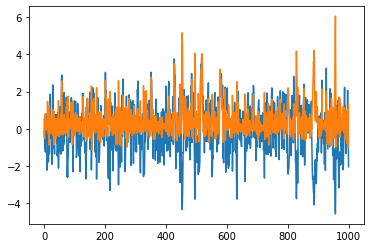

In [3]:
tstart=time.time()
hmc_results = hmc(log_p, torch.randn(2), n_samples=1000, mass=torch.tensor([0.1, 0.1]))
telapse = time.time()-tstart
print(f"Got 1000 samples in {telapse} seconds with {hmc_results['accept']*100:.2f}% acceptance")
effective_num_samples = ess(hmc_results['samples']).numpy()
print(f"Effective sample size is {effective_num_samples}")

plt.figure()
plt.plot(hmc_results['samples'])
plt.show()

Do classic VI on $q(x;\theta)$

Text(0, 0.5, 'KL(q||p) + log Z')

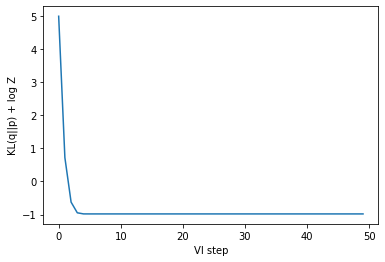

In [4]:
q_vi = MVN.new_random(d=2)
q_vi.theta.requires_grad_(True)

def _kl_q_p_helper():
    kl = -q_vi.entropy() - q_vi.quadrature_ev(log_p, 5)
    grad_kl = torch.autograd.grad(kl, q_vi.theta, create_graph=True)[0]
    hess = torch.zeros(q_vi.n_params, q_vi.n_params)
    for i in range(q_vi.n_params):
        hess[i, :] = torch.autograd.grad(grad_kl[i], q_vi.theta, retain_graph=True)[0]
    return kl.detach(), grad_kl.detach(), hess

kl_vals = torch.zeros(50)
for i in range(50):
    kl_vals[i], grad, hess = _kl_q_p_helper()
    with torch.no_grad():
        # Newton's method step
        q_vi.theta.copy_(q_vi.theta - torch.linalg.solve(hess, grad))
q_vi.theta.requires_grad_(False)

plt.figure()
plt.plot(kl_vals)
plt.xlabel('VI step')
plt.ylabel('KL(q||p) + log Z')

Do our parametric-sampling method

Got 1000 samples in 62.256908655166626 seconds with 100.00% acceptance


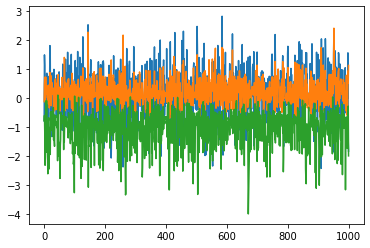

In [5]:
tstart=time.time()
mvn_hmc_results = stams_mvn_hmc(log_p, lam_kl=2.0, q_init=MVN.new_random(d=2), n_samples=1000)
telapse = time.time()-tstart
print(f"Got 1000 samples in {telapse} seconds with {hmc_results['accept']*100:.2f}% acceptance")

plt.figure()
plt.plot(mvn_hmc_results['samples'])

## Figure 1: conceptual introduction to sampling, VI, and our intermediate method

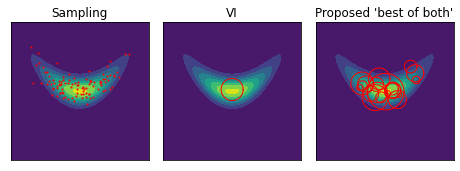

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(6.5, 2.5))

ax[0].contourf(xx, yy, p_grid, origin='lower', vmin=0.)
xl, yl = ax[0].get_xlim(), ax[0].get_ylim()
ax[0].set_title('Sampling')
ax[0].set_xticks([]); ax[0].set_yticks([])
ax[0].set_xlim(xl); ax[0].set_ylim(yl)
ax[0].axis('image')
ax[0].plot(hmc_results['samples'][::10,0], hmc_results['samples'][::10,1], '.r', markersize=2)

ax[1].contourf(xx, yy, p_grid, origin='lower', vmin=0.)
ax[1].set_title('VI')
ax[1].set_xticks([]); ax[1].set_yticks([])
ax[1].set_xlim(xl); ax[1].set_ylim(yl)
ax[1].axis('image')
ax[1].plot(*q_vi.ellipse(nsigma=1.), color='r', linewidth=1)

ax[2].contourf(xx, yy, p_grid, origin='lower', vmin=0.)
ax[2].set_title("Proposed 'best of both'")
ax[2].set_xticks([]); ax[2].set_yticks([])
ax[2].set_xlim(xl); ax[2].set_ylim(yl)
ax[2].axis('image')
for theta in mvn_hmc_results['samples'][::50]:
    q = MVN(theta=theta)
    ax[2].plot(*q.ellipse(nsigma=1.), color='r', linewidth=1)

fig.tight_layout()